In [ ]:
from ddgs import DDGS

ddgs = DDGS()

def search_images(query, max_images=300):
    """
    Search for images using DuckDuckGo's image search.

    Args:
        query (str): The search query.
        max_images (int): The number of results to return.

    Returns:
        list: A list of image URLs.
    """
    results = ddgs.images(f'{query} photo', max_results=max_images)
    return [result['image'] for result in results]

cats = search_images("cute cats", max_images=1)
cats[0]

'https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/little-cute-kitten-serhii-kucher.jpg'

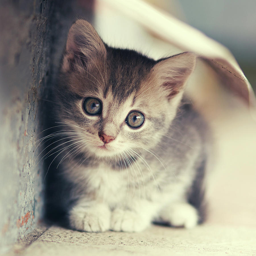

In [2]:
from fastdownload import download_url
out_dir = 'local_data/images'
dest = f'{out_dir}/cats/cat.jpg'
download_url(cats[0], dest, show_progress=False)

from fastai.vision.all import Image
im = Image.open(dest)
im.to_thumb(256, 256)

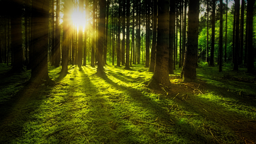

In [3]:
download_url(search_images("forest", max_images=1)[0], f'{out_dir}/forests/forest.jpg', show_progress=False)
Image.open(f'{out_dir}/forests/forest.jpg').to_thumb(256, 256)

In [ ]:
categories = {
    'cats': f'{out_dir}/cats',
    'dogs': f'{out_dir}/dogs',
    'forests': f'{out_dir}/forests',
    'mountains': f'{out_dir}/mountains',
    'cities': f'{out_dir}/cities'
}

import os, time
from fastai.vision.all import download_images, URLs
from pathlib import Path
for category, path in categories.items():
    if not os.path.exists(path):
        os.makedirs(path)
    images = search_images(category)
    download_images(path, urls=images)
    time.sleep(10)  # To avoid hitting the server too hard

In [5]:
# Cleanup failed images
from fastai.vision.all import get_image_files, verify_images
for category, path in categories.items():
    path = Path(path)
    failed = verify_images(get_image_files(path))
    if len(failed) > 0:
        print(f"Removing {len(failed)} failed images from {category}")
        failed.map(Path.unlink) # Delete the failed images
    else:
        print(f"All images in {category} are valid.")

Removing 4 failed images from cats
Removing 5 failed images from dogs
Removing 4 failed images from forests
Removing 4 failed images from mountains
Removing 11 failed images from cities


/Users/mohitsakhuja/Documents/personal/deep-learning-for-coders/.venv/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


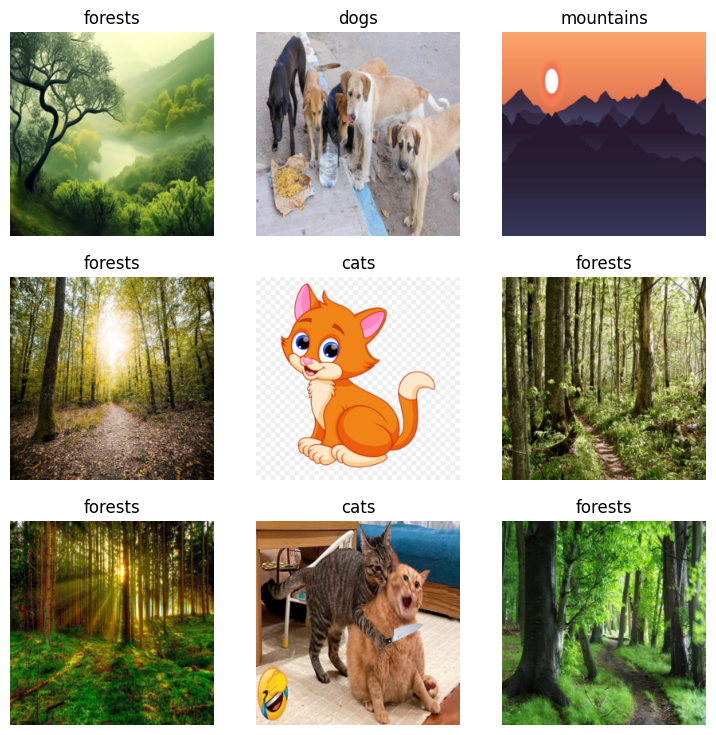

In [6]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, DataLoader, Resize, parent_label

MAX_IMAGE_SIZE = 256

dataloaders = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(MAX_IMAGE_SIZE, method='squish')]
).dataloaders(source='.', path=f'{out_dir}/images', bs=32)

dataloaders.show_batch(max_n=9)

In [13]:
import torch

# Set device to MPS (Metal Performance Shaders) for Apple Silicon
device_type = "mps" if torch.backends.mps.is_available() else "cpu"
device_type

'mps'

In [14]:
from fastai.vision.all import vision_learner, resnet18, error_rate

device = torch.device(device_type)

def train_model(dls, model, device):
    """
    Train the model using the provided learner and model on the specified device.

    Args:
        dls: The DataLoaders object containing training and validation data.
        model: The model to be trained.
        device: The device to train on (e.g., 'cpu', 'mps').
    """
    learner = vision_learner(dls, model, metrics=error_rate)
    learner.model = learner.model.to(device)

    # Fine tune the model. Three runs usually mean slight overfitting, but it can be useful for small datasets.
    # Adjust the number of epochs based on your dataset size and complexity.
    learner.fine_tune(3)

    return learner

# Train a ResNet18 model
learn_resnet18 = train_model(dataloaders, resnet18, device)


epoch,train_loss,valid_loss,error_rate,time
0,1.125886,0.484636,0.143396,01:55


/Users/mohitsakhuja/Documents/personal/deep-learning-for-coders/.venv/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.429843,0.430876,0.109434,03:13
1,0.315145,0.507789,0.120755,05:19
2,0.202842,0.487025,0.120755,04:24


In [ ]:
# Download another image to test both the models
test_image_url = search_images("cute cat", max_images=1)[0]
test_image_path = f'{out_dir}/test/cat.jpg'
download_url(test_image_url, test_image_path, show_progress=False)
from fastai.vision.all import PILImage
test_image = PILImage.create(test_image_path)

def predict_image(learner, image, model_name):
    """
    Predict the class of an image using a trained learner.

    Args:
        learner: The trained fastai learner.
        image: The image to predict.

    Returns:
        tuple: (is_cat, label, probabilities)
    """
    is_cat, label, probabilities = learner.predict(image)
    print(f"{model_name} Prediction:")
    print(f"This is a {'cat' if is_cat == 'cats' else 'dog'} image.")
    print(f"Probability of being a cat: {probabilities[0]:.4f}\n")

# Predict using the ResNet18 model
predict_image(learn_resnet18, test_image, "ResNet18")

ResNet18 Prediction:
This is a cat image.
Probability of being a cat: 0.9423



ResNet50 Prediction:
This is a cat image.
Probability of being a cat: 0.9927



ResNet152 Prediction:
This is a cat image.
Probability of being a cat: 0.9981

